# ДЗ-1

### Импорт библиотек

In [58]:
import math
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn import linear_model
from sklearn.metrics import mean_absolute_error
from datetime import date

### Пункт 1

Скачаем данные в формате csv.

In [59]:
path_to_data = "owid-covid-data.csv"
data = pd.read_csv(path_to_data, parse_dates=True)

In [60]:
data.head()

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million
0,AFG,Asia,Afghanistan,2020-02-24,5.0,5.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
1,AFG,Asia,Afghanistan,2020-02-25,5.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
2,AFG,Asia,Afghanistan,2020-02-26,5.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
3,AFG,Asia,Afghanistan,2020-02-27,5.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
4,AFG,Asia,Afghanistan,2020-02-28,5.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN


Выберем из таблицы данные по России, начиная с 3 марта 2020 г. (в этот момент впервые стало больше 2 заболевших).

In [61]:
data = data[(data["location"] == "Russia") & (data["date"] >= "2020-03-03")]
data.set_index("date", inplace=True)

В качестве целевой переменной возьмём число случаев заболевания (столбцы total_cases и new_cases); для упрощения обработки можно заменить в столбце new_cases все нули на единицы.

In [62]:
targets = ["total_cases", "new_cases"]

target_data = data[targets]

# muting the useless warning
pd.options.mode.chained_assignment = None
# simplify 'new_cases' column
target_data["new_cases"] = target_data["new_cases"].map(lambda value: value if value > 0 else 1)

Для единообразия давайте зафиксируем тренировочный набор в виде первых 50 отсчётов (дней), начиная с 3 марта; остальные данные можно использовать в качестве тестового набора (и он даже будет увеличиваться по мере выполнения задания).
Уже прошло очень много времени с начала эпидемии, поэтому логично будет данные ограничить, ибо реальную зависимость вряд ли можно предсказать столь простыми моделями. А для чисто исследовательской цели (при это исследуем мы линейную регрессию, а не короновирус) нам хватит и ограниченного датасета.

In [63]:
CARDINALITY_OF_TRAIN = 50
CARDINALITY_OF_TEST = 500

train_data = data[:CARDINALITY_OF_TRAIN]
test_data = data[CARDINALITY_OF_TRAIN:CARDINALITY_OF_TRAIN + CARDINALITY_OF_TEST]

train_target = target_data[:CARDINALITY_OF_TRAIN]
test_target = target_data[CARDINALITY_OF_TRAIN:CARDINALITY_OF_TRAIN + CARDINALITY_OF_TEST]

In [64]:
days = [i for i in range(CARDINALITY_OF_TRAIN + CARDINALITY_OF_TEST)]
days_train = days[:CARDINALITY_OF_TRAIN]
days_test = days[CARDINALITY_OF_TRAIN:CARDINALITY_OF_TRAIN + CARDINALITY_OF_TEST]

### Пункт 2

In [65]:
def plot_graphs(x, ys, title=None, labels=None, xlabel=None, ylabel=None):
    plt.figure(figsize=(16, 9))
    
    for i in range(len(ys)):
        plt.plot(x, ys[i], label=labels[i] if labels else None)

    if title:
        plt.title(title)
    if xlabel:
        plt.xlabel(xlabel)
    if ylabel:
        plt.ylabel(ylabel)
    if labels:
        plt.legend()
    
    plt.show()

Строим графики для всех данных (на момент выгрузки датасета).

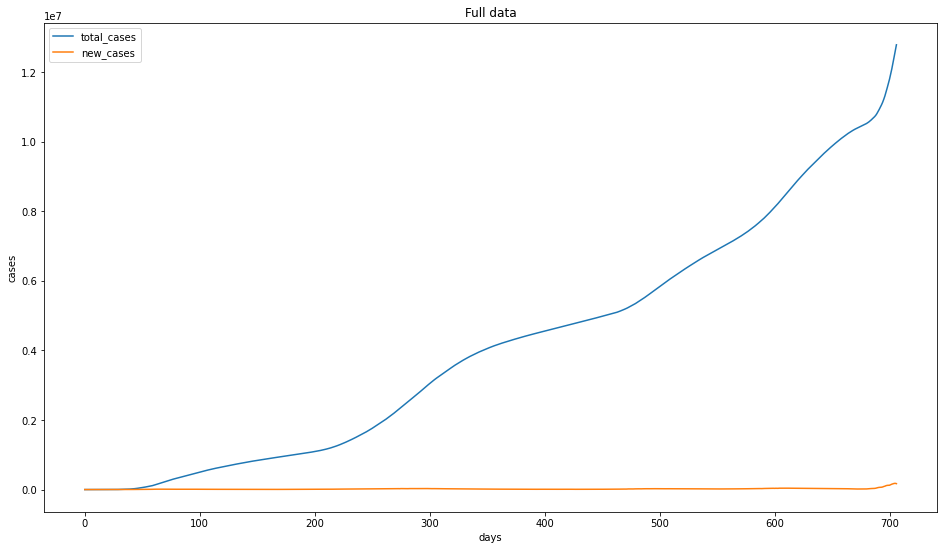

In [66]:
plot_graphs(range(len(data.index)), [data[target] for target in targets],
            title="Full data", labels=targets,
            xlabel="days", ylabel="cases")

Строим графики для тренировочных данных.

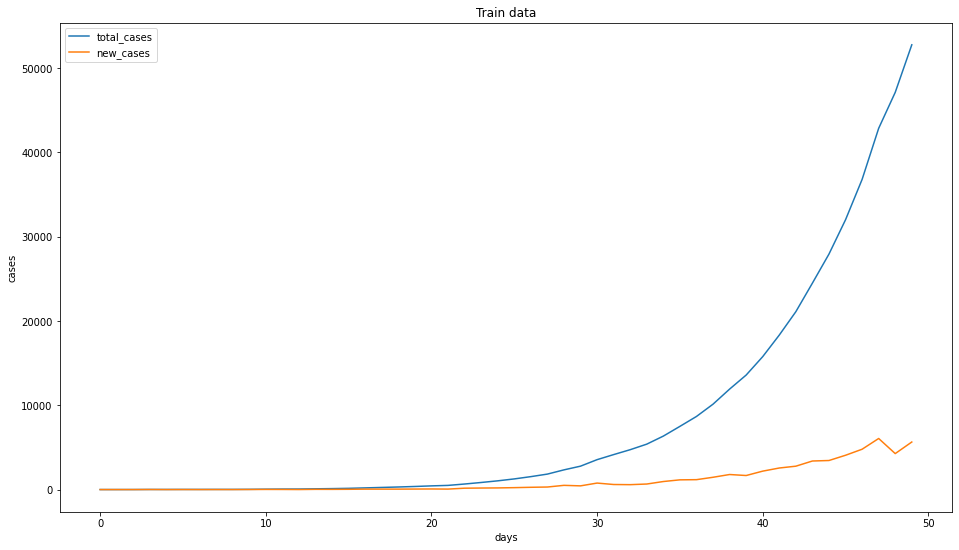

In [67]:
plot_graphs(days_train, [train_target[target] for target in targets],
            title="Train data", labels=targets,
            xlabel="days", ylabel="cases")

Теперь построим графики для наших "обрезанных" данных, на которых мы и будем оценивать нашу модель.

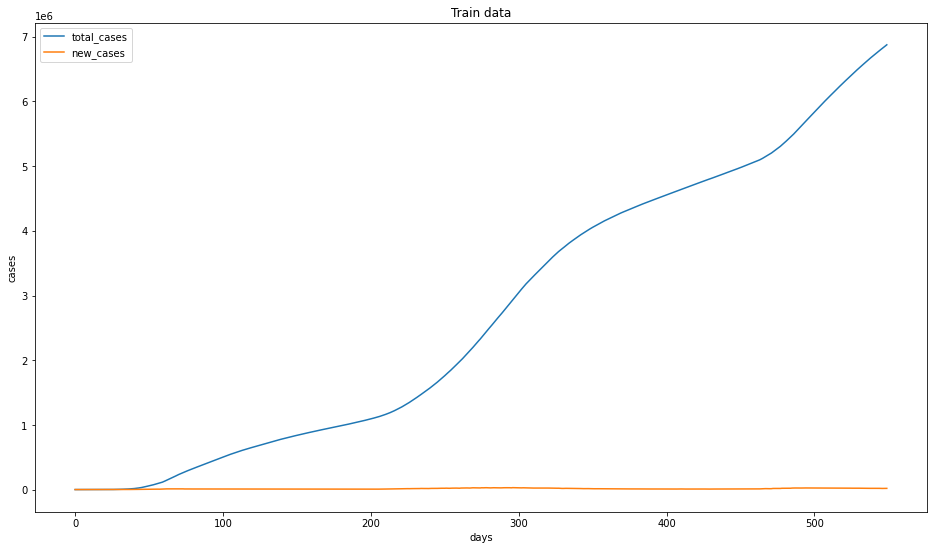

In [68]:
plot_graphs(days, [train_target[target].append(test_target[target]) for target in targets],
            title="Train data", labels=targets,
            xlabel="days", ylabel="cases")

Видим, что число заболевших растёт очень быстро, на первый взгляд экспоненциально. Для первого подхода к снаряду давайте это и используем.

#### Подпункт A

Используя линейную регрессию, обучим модель с экспоненциальным ростом числа заболевших: y ~ exp(линейная функция от x), где x — номер текущего дня.

Будем использовать линейную регрессию не для исходной функции, а сделаем небольшие (и обратимые) преобразования нашей целевой функций:

$$
y \sim exp(w * x + b);\\
y = C1 * exp(w * x + b);\\
ln(y) = ln(C1) + w * x + b;\\
$$

пускай $C2 = ln(C1) + b$ и $g = ln(y)$. В результате, функция для модели линейной регрессии будет выглядеть так:
$$g = w * x + C2;$$
тогда мы можем обратить предсказанный результат линейной регрессии, чтобы получить нашу исходную функцию: $y = exp(g)$.

In [69]:
train_target_log = pd.DataFrame()
test_target_log = pd.DataFrame()

for target in targets:
    train_target_log[target] = train_target[target].map(lambda value: math.log(value))
    test_target_log[target] = test_target[target].map(lambda value: math.log(value))

Проиллюстрируем нашу полученную функцию (по нашему предположению, она должна быть похожа на прямую).

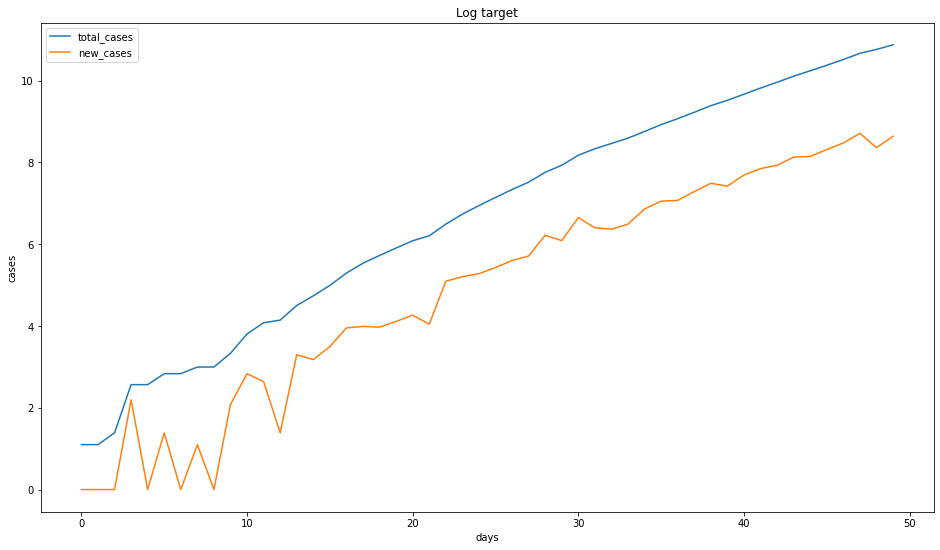

In [70]:
plot_graphs(days_train, [train_target_log[target] for target in targets],
            title="Log target", labels=targets,
            xlabel="days", ylabel="cases")

Вроде такое можно пытаться аппроксимировать прямой :)

In [71]:
def linear_log(xs, ys, target=None, plot=False):
    model = linear_model.LinearRegression()
    model.fit(xs, ys)

    w = model.coef_
    b = model.intercept_
    print("w = {}, b = {}".format(w, b))

    pred = model.predict(xs)

    if plot:
        plot_graphs(days_train, [train_target_log[target], pred],
                    title="Liner regression for " + target,
                    labels=["реальные данные", "ML гипотеза"],
                    xlabel="days", ylabel="cases")

    return (pred, w, b)

Посмотрим, насколько хорошо получилось это сделать.

w = [0.19829091], b = 1.820737148784695


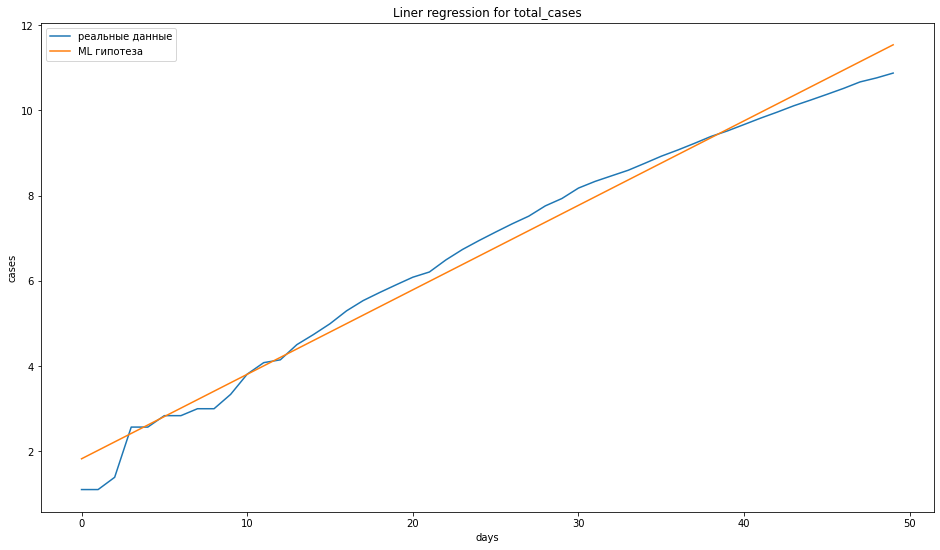

w = [0.18596309], b = 0.3206875188996463


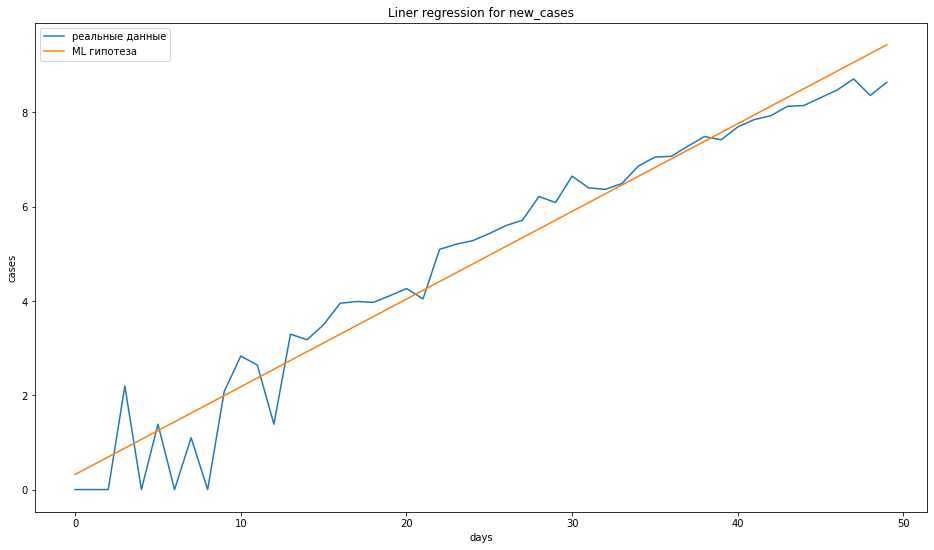

In [72]:
gs = {}
ws = {}
C2s = {}

for target in targets:
    parameters = linear_log(np.array(days_train).reshape(-1, 1),
                         train_target_log[target],
                         target, True)
    gs[target] = parameters[0]
    ws[target] = parameters[1]
    C2s[target] = parameters[2]

Вроде неплохо. Теперь можем обратить выход линейной регрессии, чтобы найти значения изначальной целевой функции.

In [73]:
ys = {}

for target in targets:
    ys[target] = [math.exp(value) for value in gs[target]]

Проиллюстрируем, что получилось.

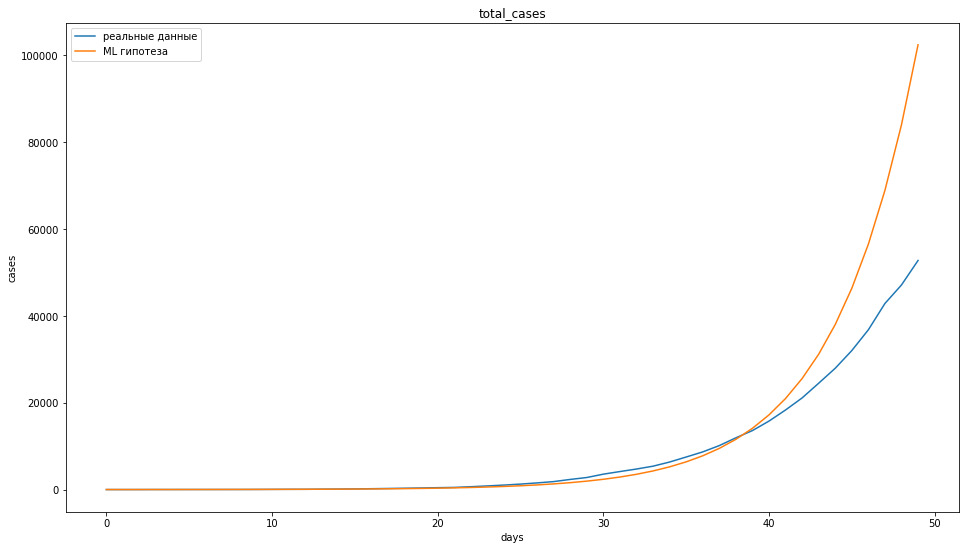

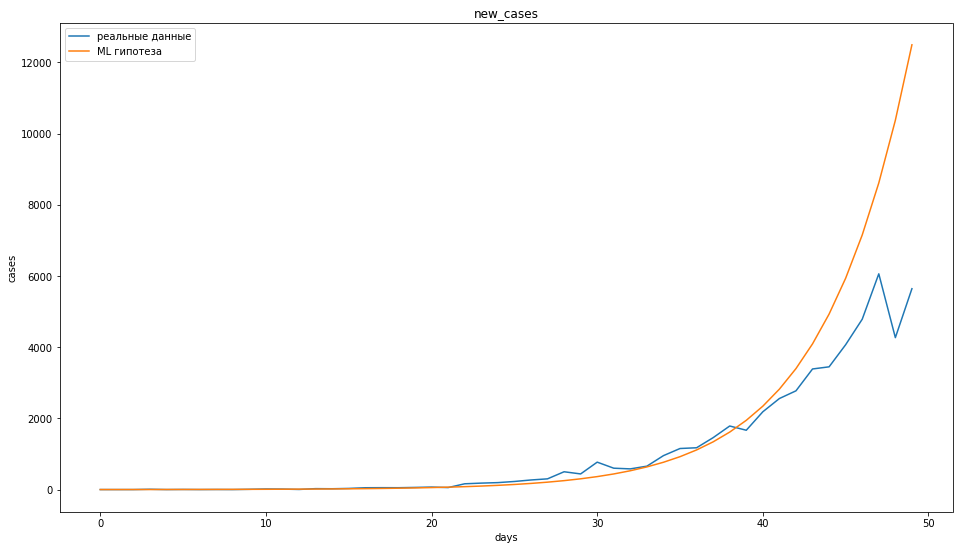

In [74]:
for target in targets:
    plot_graphs(days_train, [train_target[target], ys[target]],
                title=target, labels=["реальные данные", "ML гипотеза"],
                xlabel="days", ylabel="cases")

#### Подпункт B

Теперь посчитаем MAE на тренировочной выборке для нашей модели (именно линейной, для $g = w * x + C2$). Эта ошибка по факту является значением дисперсии шума в данных  $\sigma^{2}$ (это фактически первый шаг эмпирического Байеса).

In [75]:
maes = {}

for target in targets:
    maes[target] = mean_absolute_error(train_target_log[target],
                                       gs[target])
    print("MAE for {} target is {}".format(target, maes[target]))

MAE for total_cases target is 0.2867742094023083
MAE for new_cases target is 0.4634998976530288


Возьмем априорное распределение как $P(\overline{w}) = N(\overline{w} | \overline{0}, \frac{1}{\alpha} E)$, где $\alpha$ - некий наперед заданный гиперпараметр (относящийся к параметру регуляризации L2), а $\overline{w} = [w, C2]^{T}$.  
Тогда по формуле для сопряженных априорных распределений к линейной регрессии, которую мы выводили на лекции, можно оценить апостериорное распределение $P(\overline{w} | D)$. Ведь все параметры для правдоподобия уже тоже посчитаны выше $P(D | \overline{w}) = \prod_{n = 1}^{50} p(y_{n} | \overline{w}, \overline{x}_{n}) = \prod_{n = 1}^{50} N(y_{n} | \overline{w} ^{T} \overline{x}_{n}, \sigma^{2})$

Непосредственно сама формула $P(\overline{w} | D) = N(\overline{w} | \mu, \Sigma)$, где
$$
\Sigma = (\Sigma_{0}^{-1} + \frac{1}{\sigma^{2}} X^{T} X)^{-1},\\
\mu = \Sigma (\Sigma_{0}^{-1} \mu_{0}  + \frac{1}{\sigma^{2}} X^{T} \overline{y}).\\
$$

In [76]:
def bayesian_update_quantity(mu, sigma, xs, ys, mae):
    x_matrix = np.array([[1, x] for x in xs])
    y_matrix = np.array([[1, y] for y in ys])

    sigma_n = np.linalg.inv(np.linalg.inv(sigma) +
              (1 / mae) * x_matrix.T @ x_matrix)
    mu_n = sigma_n @ (np.linalg.inv(sigma) @ mu +
           (1 / mae) * (np.array(xs)).T @ y_matrix)

    return mu_n, sigma_n

In [77]:
alpha = 2
mu_sigma = {}

for target in targets:
    mu_sigma[target] = bayesian_update_quantity(
        np.array([0, 0]), alpha * np.array([[1, 0], [0, 1]]),
        days_train, train_target_log[target],
        maes[target])

In [78]:
for target in targets:
    print(target)
    print(mu_sigma[target])

total_cases
(array([70.22617331, -1.87459444]), array([[ 2.20217675e-02, -6.67323921e-04],
       [-6.67323921e-04,  2.73158218e-05]]))
new_cases
(array([75.1514772 , -2.08162466]), array([[ 3.53526591e-02, -1.07128656e-03],
       [-1.07128656e-03,  4.39286518e-05]]))


In [79]:
def bayesian_update(mu, sigma, x, y, mae):
    sigma_n = np.linalg.inv(np.linalg.inv(sigma) +
              (1 / mae) * np.array(x).T @ np.array(x))
    mu_n = sigma_n @ (np.linalg.inv(sigma) @ mu +
           (1 / mae) * np.array(x).T @ np.array([y]))

    return mu_n, sigma_n

In [80]:
alpha = 2
mu_sigma = {}

for target in targets:
    mu, sigma = np.array([0, 0]), alpha * np.array([[1, 0], [0, 1]])
    for i in days_train:
        mu, sigma = bayesian_update(mu, sigma,
                                    [[1, i]],
                                    train_target_log[target].iloc[i],
                                    maes[target])
    mu_sigma[target] = (mu, sigma)

In [81]:
for target in targets:
    print(target)
    print(mu_sigma[target])

total_cases
(array([1.80075539, 0.19889571]), array([[ 2.20217675e-02, -6.67323921e-04],
       [-6.67323921e-04,  2.73158218e-05]]))
new_cases
(array([0.31511855, 0.18613078]), array([[ 3.53526591e-02, -1.07128656e-03],
       [-1.07128656e-03,  4.39286518e-05]]))


#### Подпункт C

Посэмплируем много разных экспонент, построим графики.

In [82]:
def get_and_plot_sample_lines(mu, sigma,
                              xs, ys,
                              title=None,
                              xlabel=None,
                              ylabel=None):
    plt.figure(figsize=(16, 9))

    samples = []
    for w in np.random.multivariate_normal(mu, sigma, 20):
        sample = [w[0] + w[1] * x for x in xs]
        samples.append(sample)
        plt.plot(xs, sample, 'k-')
    
    plt.scatter(xs, ys)
    
    if title:
        plt.title(title)
    if xlabel:
        plt.xlabel(xlabel)
    if ylabel:
        plt.ylabel(ylabel)

    plt.show()

    return samples

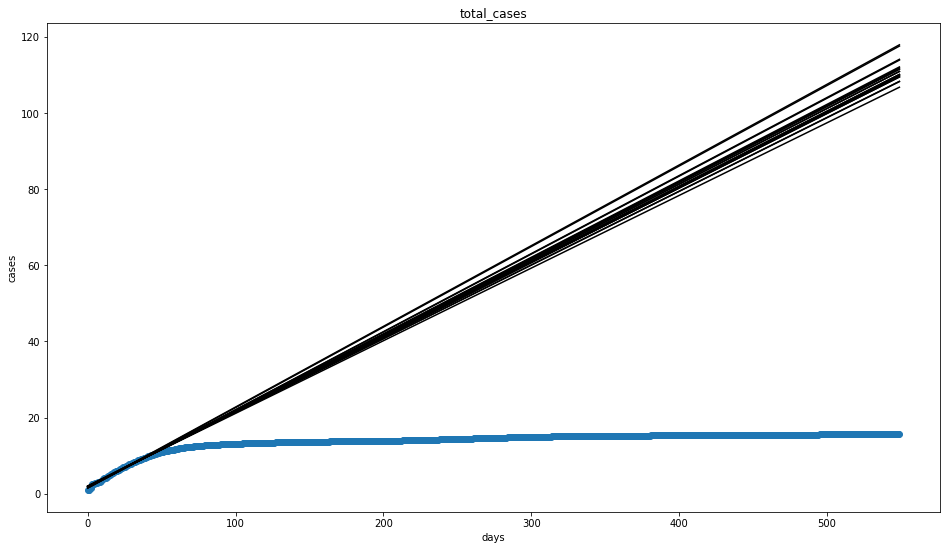

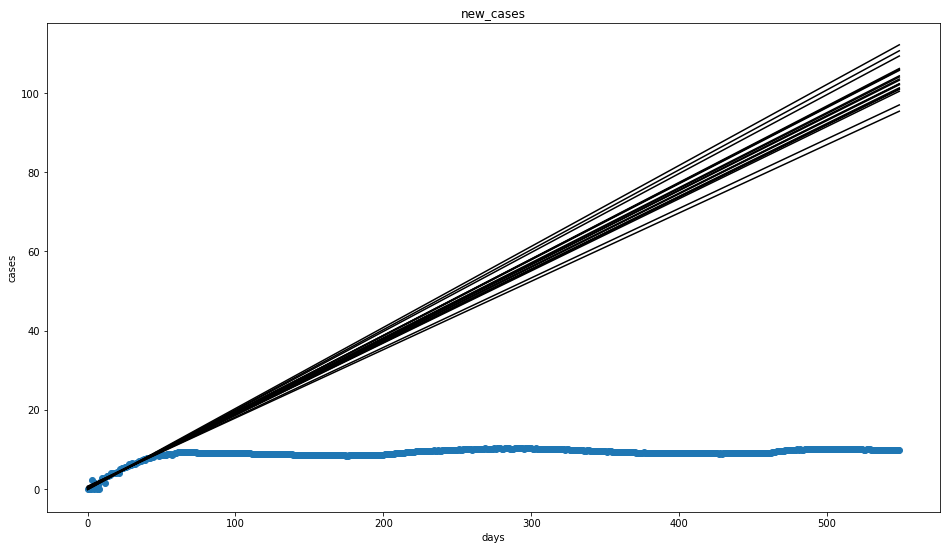

In [83]:
samples = {}

for target in targets:
    samples[target] = get_and_plot_sample_lines(
                        mu_sigma[target][0],
                        mu_sigma[target][1],
                        days,
                        train_target_log[target].append(test_target_log[target]),
                        target,
                        "days",
                        "cases")

Теперь давайте посмотрим на исходную целевую фунцию, насколько хорошо наше предположение об экспоненциальном росте числа заболевших будет работать на тестовых данных.

In [122]:
def plot_sample_exp(samples,
                    xs, ys,
                    title=None, xlabel=None, ylabel=None):
    plt.figure(figsize=(16, 9))

    for sample in samples:
        plt.plot(xs, [math.exp(value) for value in sample], 'k-')
    
    plt.scatter(xs, np.exp(ys))
    
    if title:
        plt.title(title)
    if xlabel:
        plt.xlabel(xlabel)
    if ylabel:
        plt.ylabel(ylabel)

    plt.show()

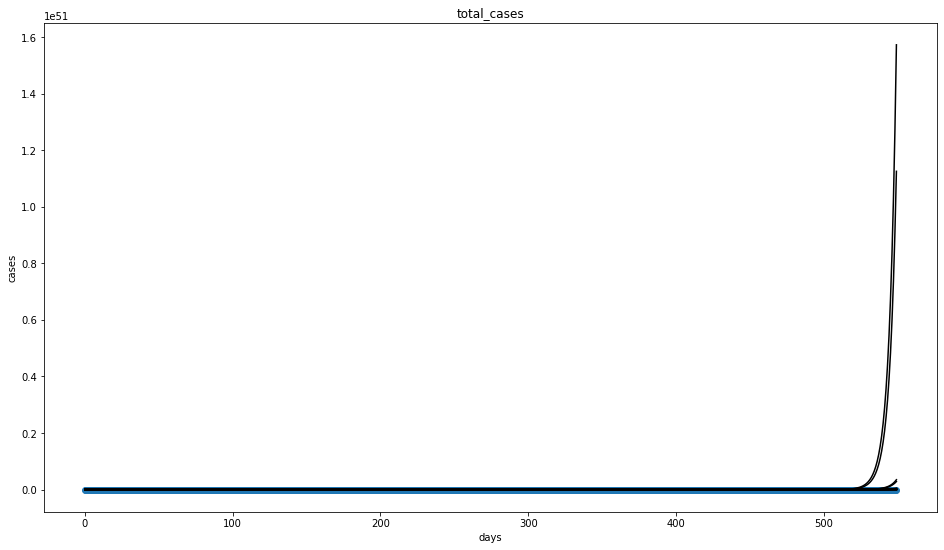

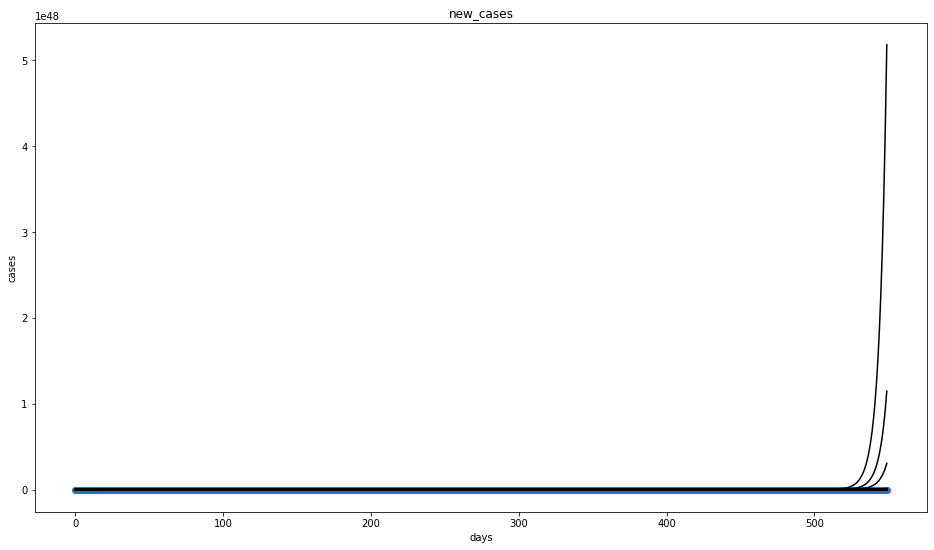

In [124]:
for target in targets:
    plot_sample_exp(samples[target],
                    days,
                    train_target_log[target].append(test_target_log[target]),
                    target,
                    "days",
                    "cases")

Даже из графиков очевидно, что такая модель слишком пессимистична. Это также видно, если посмотреть разницу реального количества случаев короновируса и прогнозом нашей модели на 1 мая, 1 июня, 1 сентября.

In [86]:
start_day = date(2020, 3, 1)
day_names = ["1 мая", "1 июня", "1 сентября"]
check_days =[(date(2020, 5, 1) - start_day).days,
              (date(2020, 6, 1) - start_day).days,
              (date(2020, 9, 1) - start_day).days]

message = "Реальные случаи короновируса на {}: {}. \n"\
          "Предсказание нашей модели: {}. \n"\
          "Разница: {}\n"

for target in targets:
    print("Для {}:".format(target))

    for i in range(len(day_names)):
        real_for_day = target_data[target].iloc[check_days[i]]
        pred_for_day = math.exp(mu_sigma[target][0][0] + 
                                check_days[i] * mu_sigma[target][0][1])
        print(message.format(day_names[i],
                            real_for_day,
                            pred_for_day,
                            abs(pred_for_day - real_for_day)))

Для total_cases:
Реальные случаи короновируса на 1 мая: 134687.0. 
Предсказание нашей модели: 1125112.95162502. 
Разница: 990425.95162502

Реальные случаи короновируса на 1 июня: 431715.0. 
Предсказание нашей модели: 535740869.40531564. 
Разница: 535309154.40531564

Реальные случаи короновируса на 1 сентября: 1006923.0. 
Предсказание нашей модели: 4.740797759916852e+16. 
Разница: 4.74079775981616e+16

Для new_cases:
Реальные случаи короновируса на 1 мая: 10633.0. 
Предсказание нашей модели: 116902.578727899. 
Разница: 106269.578727899

Реальные случаи короновируса на 1 июня: 8529.0. 
Предсказание нашей модели: 37473719.24378631. 
Разница: 37465190.24378631

Реальные случаи короновируса на 1 сентября: 4958.0. 
Предсказание нашей модели: 1024706166583489.2. 
Разница: 1024706166578531.2



В общем такой подход вообще никуда не годится. Ибо разница и так огромная, да еще и растет очень быстро. Также кроме того, что байесовский вывод по своей сути не сильно может в экстраполяцию, так еще и экспонента как функция не сильно к ошибкам устойчива (для разных прямых могут быть очень разные экспоненты по мере увеличения аргумента).

Теперь построим предсказательные распределения для наших линейных моделей чисто эмпирически, исходя из данных сэмплирования.

In [87]:
def plot_predictions_lines(xs, ys, mu, mae, samples,
                           title=None, xlabel=None, ylabel=None):
    fig = plt.figure(figsize=(16, 9))
    ax = fig.add_subplot()
    
    ax.scatter(xs, ys, color="green", label="реальные точки данных")
    ax.plot(xs, mu[0] + mu[1] * np.array(xs),
            color="blue", label="MAP гипотеза")
    ax.fill_between(xs,
                    mu[0] + mu[1] * np.array(xs) - mae,
                    mu[0] + mu[1] * np.array(xs) + mae,
                    alpha=.3, label="+- дисперсия шума")
    ax.fill_between(xs,
                    np.mean(samples, axis=0) - np.std(samples, axis=0),
                    np.mean(samples, axis=0) + np.std(samples, axis=0),
                    alpha=.2, label="+- дисперсия предсказаний")

    if title:
        plt.title(title)
    if xlabel:
        plt.xlabel(xlabel)
    if ylabel:
        plt.ylabel(ylabel)

    ax.legend()

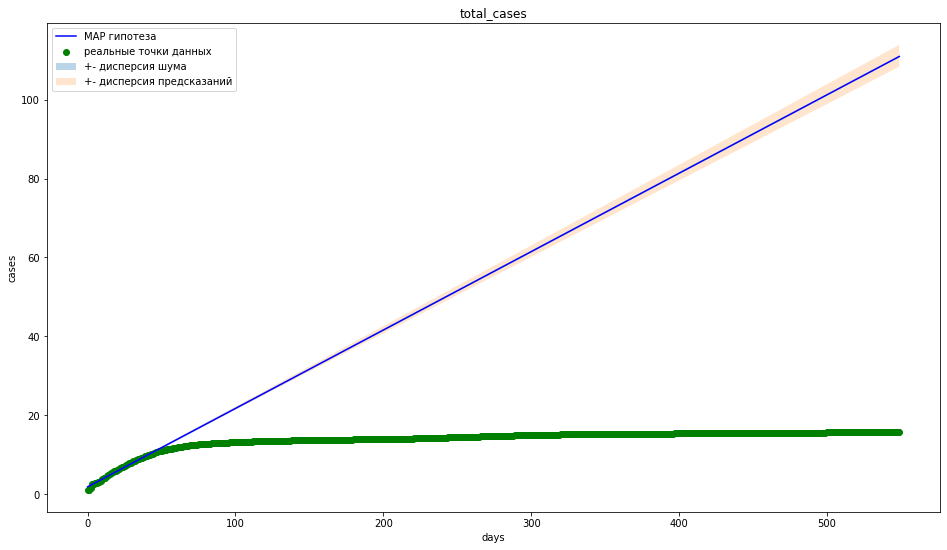

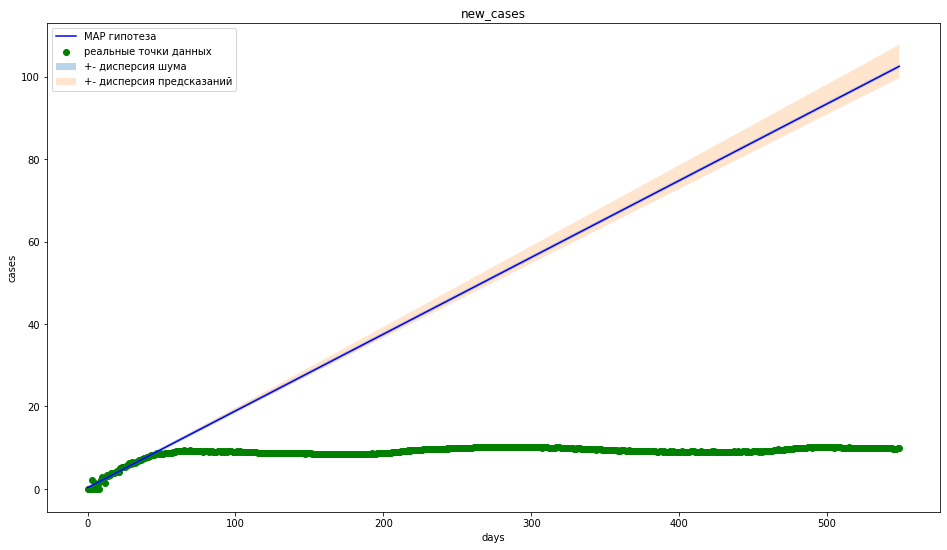

In [88]:
for target in targets:
    plot_predictions_lines(days,
                           train_target_log[target].append(test_target_log[target]),
                           mu_sigma[target][0],
                           maes[target],
                           samples[target],
                           target,
                           "days",
                           "cases")

Теперь для экспоненты.

In [89]:
def plot_predictions_exp(xs, ys, mu, mae, samples,
                         title=None, xlabel=None, ylabel=None):
    new_samples = []
    for sample in samples:
        sample = [math.exp(value) for value in sample]
        new_samples.append(sample)

    fig = plt.figure(figsize=(16, 9))
    ax = fig.add_subplot()

    ax.scatter(xs, ys, color="green", label="реальные точки данных")
    ax.plot(xs, np.exp(mu[0] + mu[1] * np.array(xs)),
            color="blue", label="MAP гипотеза")
    ax.fill_between(xs,
                    np.exp(mu[0] + mu[1] * np.array(xs) - mae), # not sure
                    np.exp(mu[0] + mu[1] * np.array(xs) + mae), # not sure
                    alpha=.3, label="+- дисперсия шума")
    ax.fill_between(xs,
                    np.mean(new_samples, axis=0) - np.std(new_samples, axis=0),
                    np.mean(new_samples, axis=0) + np.std(new_samples, axis=0),
                    alpha=.2, label="+- дисперсия предсказаний")

    if title:
        plt.title(title)
    if xlabel:
        plt.xlabel(xlabel)
    if ylabel:
        plt.ylabel(ylabel)    

    ax.legend()

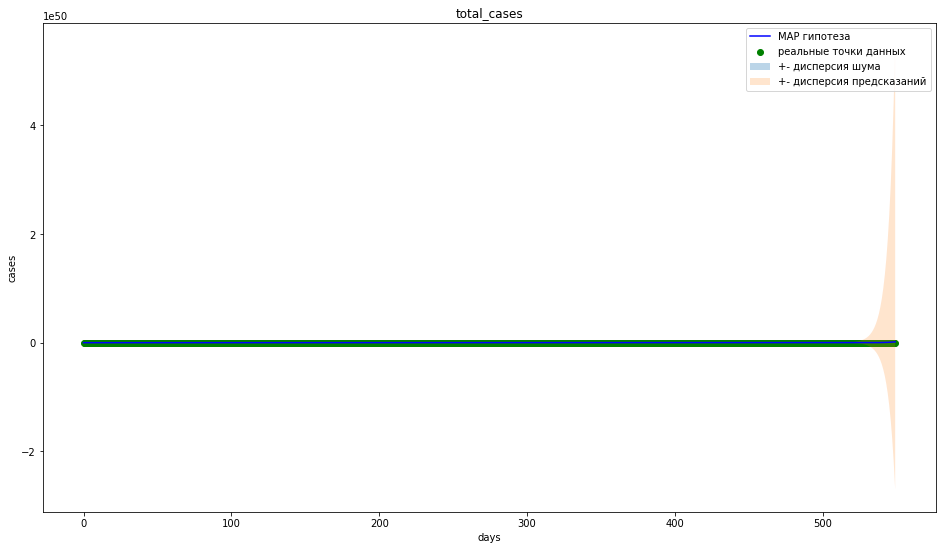

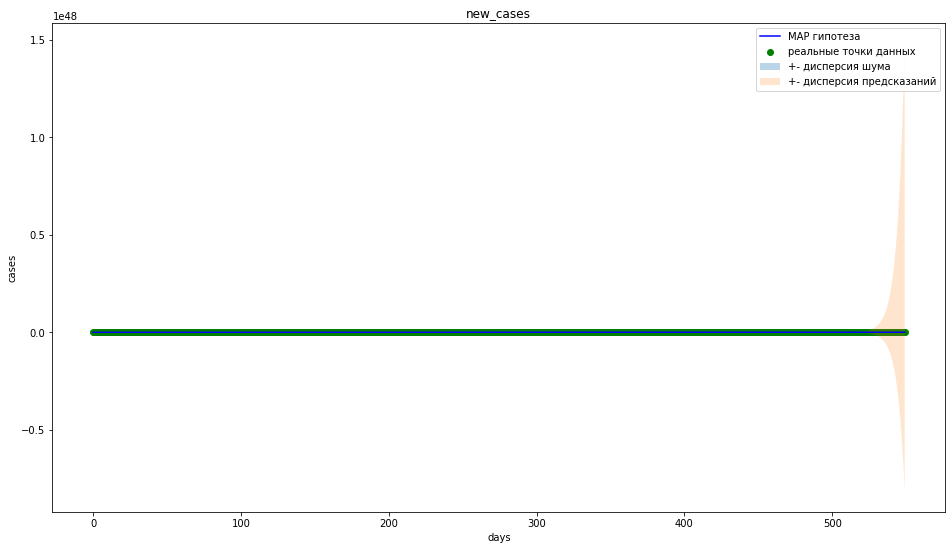

In [90]:
for target in targets:
    plot_predictions_exp(days,
                         train_target[target].append(test_target[target]),
                         mu_sigma[target][0],
                         maes[target],
                         samples[target],
                         target,
                         "days",
                         "cases")

Как можно видеть из графиков, данные new_cases достаточно шумные (это было видно еще при построении линейной модели), поэтому для них такие большие дисперсии шума и предсказаний. Также можно пронаблюдать, что дисперсия предсказаний для total_cases даже на экстраполированной области очень небольшая (хотя реальные результаты сильно отличаются от предсказанных), связанно это в первую очередь с тем, что в процессе байесовских апдейтов мы использовали достаточно большое количество точек, лежащих действительно +- на одной прямой.

### Пункт 3

Предсказания экспоненциальной модели получились грустными. Но это, конечно, чересчур пессимистично — экспоненциальный рост в природе никак не может продолжаться вечно. Кривая общего числа заболевших во время эпидемии в реальности имеет сигмоидальный вид: после начальной фазы экспоненциального роста неизбежно происходит насыщение. В качестве конкретной формы такой сигмоиды давайте возьмём форму функции распределения для гауссиана:

![Sigmoid](./sigmoid.jpg)

Естественно, в нашем случае сигмоида стремится не к единице, т.е. константа перед интегралом может быть произвольной (и её можно внести в экспоненту), а в экспоненте под интегралом может быть произвольная квадратичная функция от t.

#### Подпункт A

В итоге исходная функция будет такой: 
$$
y = \int_{-\infty}^x e^{a t ^ {2} + b t + c}\ dt.
$$

В пердыдущем пункте мы использовали экспоненту для приближения total_cases и new_cases, т к, неожиданно (нет), производная экспоненты - экспонента. В этом пукте можно воспользоваться похожей логикой. Пускай функция выше будет приближать именно total_cases. Тогда можно апроксимировать new_cases с помощью подынтегральной функции:
$$
f = e^{a t ^ {2} + b t + c}.
$$
Такое действительно будет справедливо, т к total_cases является аккумулятивной суммой всех значений new_cases с начала пандемии до некоторого дня (в который мы total_cases и смотрим).  
Теперь осталось сделать похожий шаг, который мы делали в предыдущем пункте и можно использовать линейную регрессию:
$$
ln(f) = a t ^ {2} + b t + c,\\
g = a t ^ {2} + b t + c.
$$
Понятно, что и аргументы теперь будут иными (просто квадраты номеров дней, а не сами дни).

In [91]:
days_square = [[day ** 2, day] for day in days]
days_train_square = days_square[:CARDINALITY_OF_TRAIN]
days_test_square = days_square[CARDINALITY_OF_TRAIN:CARDINALITY_OF_TRAIN + CARDINALITY_OF_TEST]

Обучим линейную регрессию. Понятно, теперь мы апроксимируем наши данные преобразованные с помощью параболы.

w = [-0.00182979  0.27562283], b = -0.39659040284162295


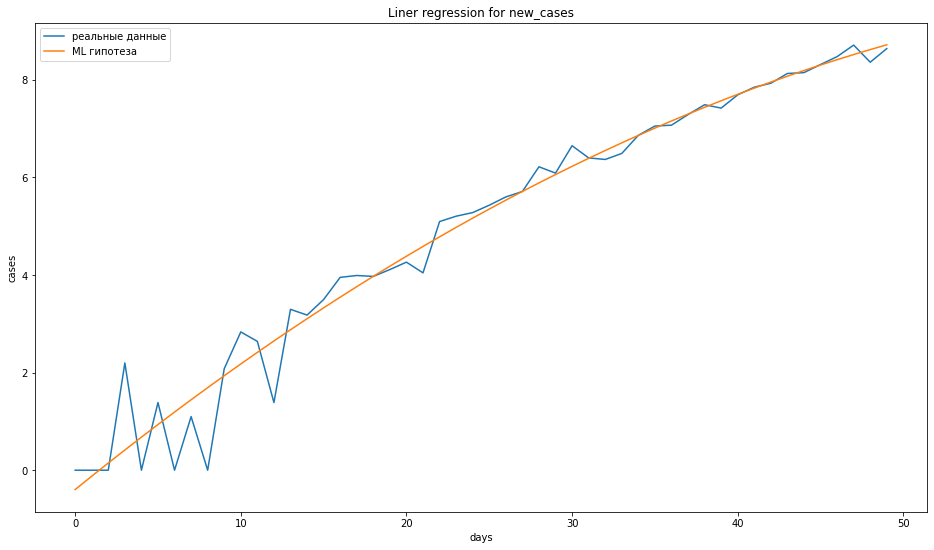

In [92]:
gs_new = []

parameters = linear_log(np.array(days_train_square),
                        train_target_log["new_cases"],
                        "new_cases", True)
gs_new = parameters[0]

Обратим преобразования.

In [93]:
ys_new = []

ys_new = [math.exp(value) for value in gs_new]

Проиллюстрируем, что получилось.

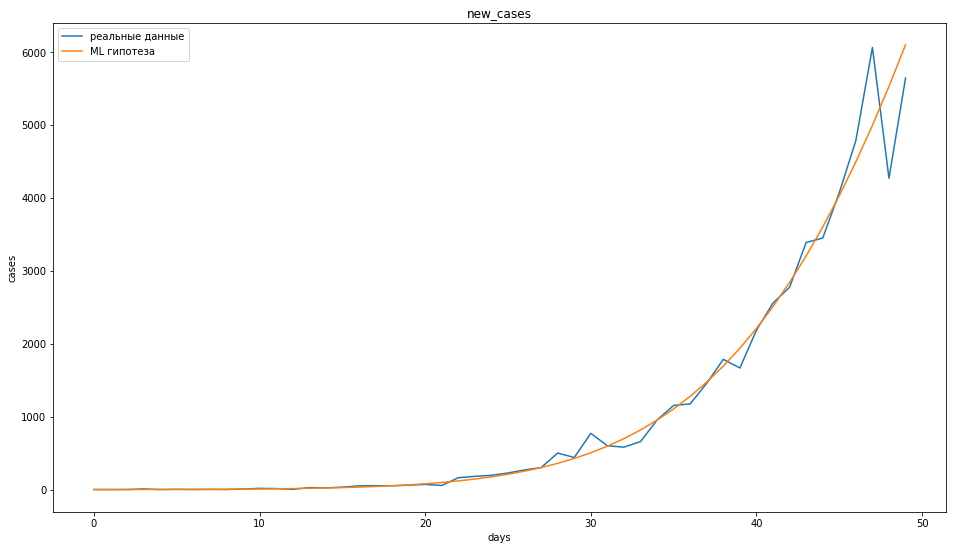

In [94]:
plot_graphs(days_train, [train_target["new_cases"], ys_new],
            title=target, labels=["реальные данные", "ML гипотеза"],
            xlabel="days", ylabel="cases")

Неплохо, теперь total_cases.

In [95]:
ys_total = []

sum = 0
for y in ys_new:
    sum += y
    ys_total.append(sum)

Проиллюстрируем, что получилось.

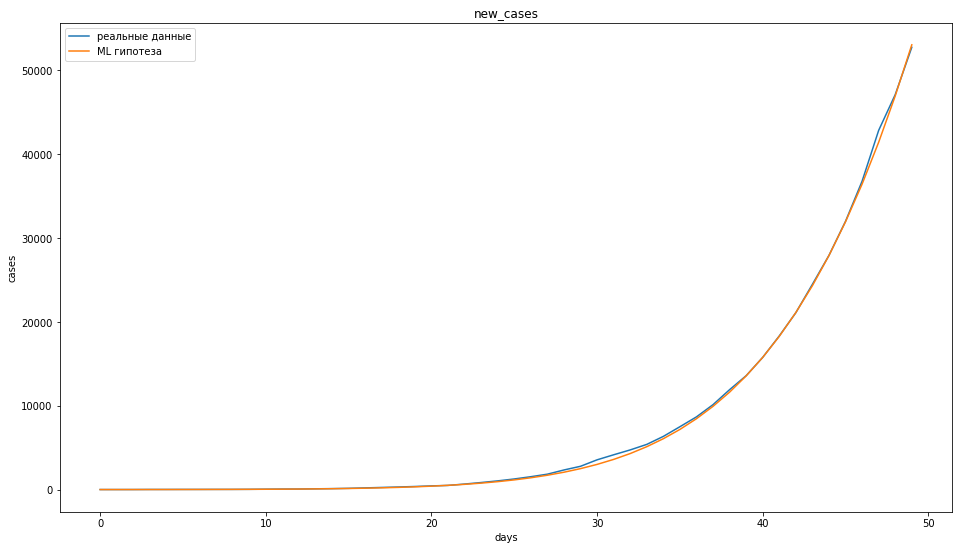

In [96]:
plot_graphs(days_train, [train_target["total_cases"], ys_total],
            title=target, labels=["реальные данные", "ML гипотеза"],
            xlabel="days", ylabel="cases")

Это был лишь первый шаг байесовского анализа в этом пунке. Идем дальше.

#### Подпункт B

Как и раньше, посчитаем MAE.

In [97]:
mae_new = mean_absolute_error(train_target_log["new_cases"],
                              gs_new)
print("MAE for {} target is {}".format("new_cases", mae_new))

MAE for new_cases target is 0.2842831338105156


Как и раньше используем готовую формулу для байесовских апдейтов найдем апостериорное распределение.

In [98]:
mu, sigma = np.array([0, 0, 0]), alpha * np.array([[1, 0, 0],
                                                   [0, 1, 0],
                                                   [0, 0, 1]])
for i in days_train:
    mu, sigma = bayesian_update(mu, sigma,
                                [[1, i, i ** 2]],
                                train_target_log["new_cases"].iloc[i],
                                mae_new)
mu_sigma_new = (mu, sigma)

#### Подпункт C

Посэмплируем много новых разных экспонент, построим графики.

In [99]:
def get_and_plot_new_sample_lines(mu, sigma,
                                 xs, ys,
                                 title=None,
                                 xlabel=None,
                                 ylabel=None):
    plt.figure(figsize=(16, 9))

    samples = []
    for w in np.random.multivariate_normal(mu, sigma, 20):
        sample = [w[0] + w[1] * x + w[2] * x ** 2 for x in xs]
        samples.append(sample)
        plt.plot(xs, sample, 'k-')
    
    plt.scatter(xs, ys)
    
    if title:
        plt.title(title)
    if xlabel:
        plt.xlabel(xlabel)
    if ylabel:
        plt.ylabel(ylabel)

    plt.show()

    return samples

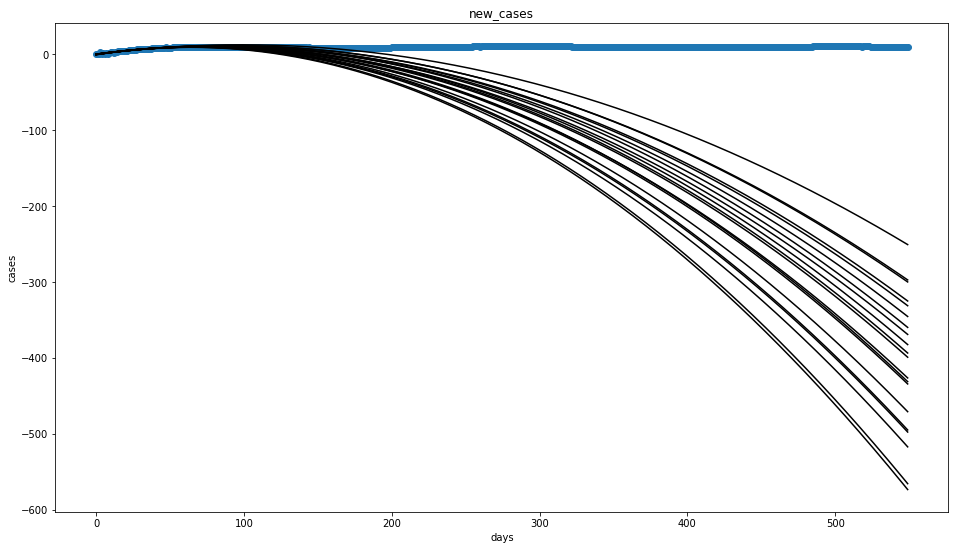

In [100]:
samples_new  = get_and_plot_new_sample_lines(
                    mu_sigma_new[0],
                    mu_sigma_new[1],
                    days,
                    train_target_log["new_cases"].append(test_target_log["new_cases"]),
                    "new_cases",
                    "days",
                    "cases")

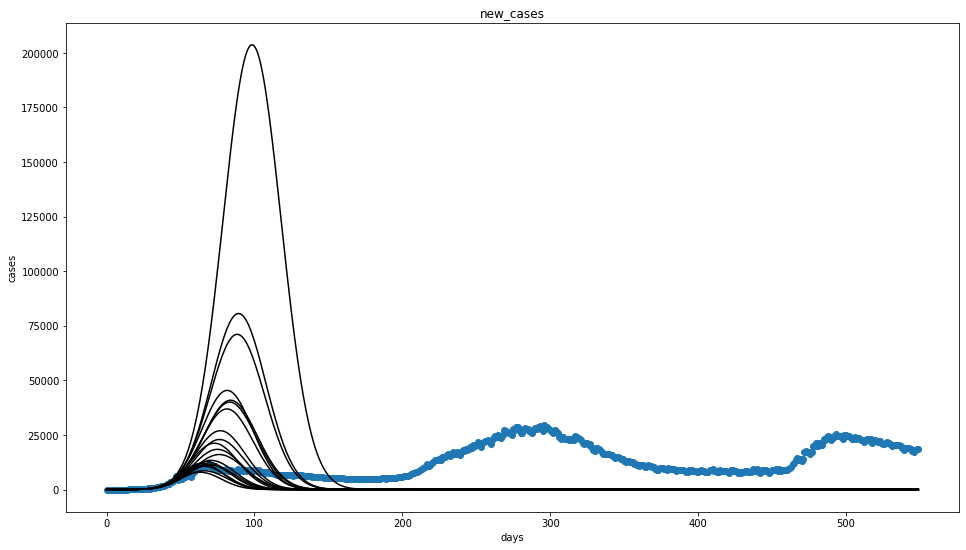

In [123]:
plot_sample_exp(samples_new,
                days,
                train_target_log["new_cases"].append(test_target_log["new_cases"]),
                "new_cases",
                "days",
                "cases")

Момент истины...

In [102]:
final_predict = []

sum = 0
for day in days:
    sum += math.exp(mu_sigma_new[0][0] +
                    mu_sigma_new[0][1] * day +
                    mu_sigma_new[0][2] * day ** 2)
    final_predict.append(sum)

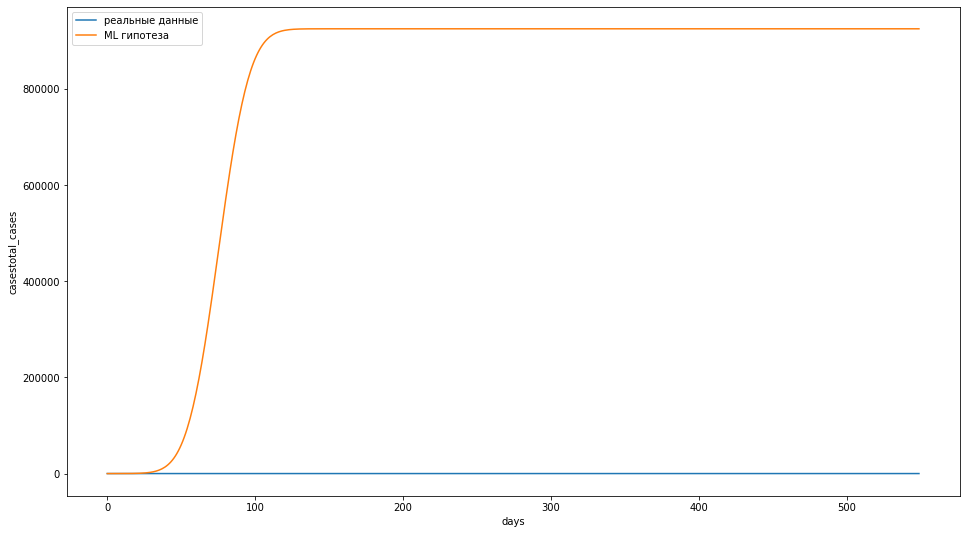

In [103]:
plot_graphs(days,
            [
                train_target_log["total_cases"].append(test_target_log["total_cases"]),
                final_predict
            ],
            labels=["реальные данные", "ML гипотеза"],
            xlabel="days", ylabel="cases"
            "total_cases")

Результаты, конечно, все еще далеки от истины, но уже куда лучше предыдущего приближения.

Теперь сэмплируем  много разных сигмоид.

In [104]:
samples_total = []

for sample_new in samples_new:
    sample_total = []
    
    sum = 0
    for x in sample_new:
        sum += math.exp(x)
        sample_total.append(sum)
    
    samples_total.append(sample_total)

И строим графики.

In [105]:
def plot_samples(samples,
                 xs, ys,
                 title=None,
                 xlabel=None,
                 ylabel=None):
    plt.figure(figsize=(16, 9))

    for sample in samples:
        plt.plot(xs, sample, 'k-')
    
    plt.scatter(xs, ys)
    
    if title:
        plt.title(title)
    if xlabel:
        plt.xlabel(xlabel)
    if ylabel:
        plt.ylabel(ylabel)

    plt.show()

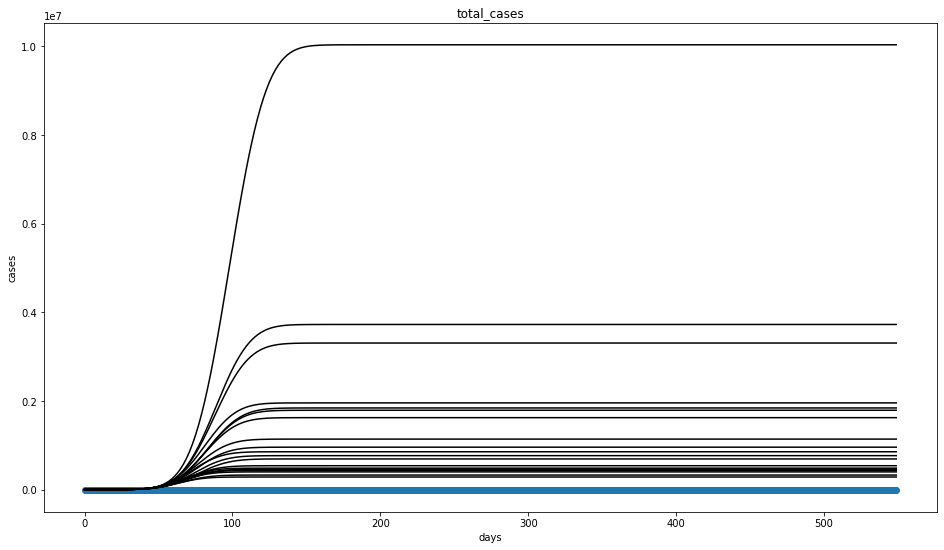

In [106]:
plot_samples(samples_total,
             days,
             train_target_log["total_cases"].append(test_target_log["total_cases"]),
             "total_cases",
             "days",
             "cases")

In [127]:
print("Общее количество заболевших короновирусом в России (худший сценарий): " +
    str(max(final_predict)))

Общее количество заболевших короновирусом в России (худший сценарий): 924765.2258879169


Теперь можем сделать прогноз на конкретные даты.

In [107]:
for i in range(len(day_names)):
    real_for_day = target_data["total_cases"].iloc[check_days[i]]
    pred_for_day = final_predict[check_days[i]]
    print(message.format(day_names[i],
                        real_for_day,
                        pred_for_day,
                        abs(pred_for_day - real_for_day)))

Реальные случаи короновируса на 1 мая: 134687.0. 
Предсказание нашей модели: 181911.7811176871. 
Разница: 47224.78111768709

Реальные случаи короновируса на 1 июня: 431715.0. 
Предсказание нашей модели: 781429.3182216253. 
Разница: 349714.3182216253

Реальные случаи короновируса на 1 сентября: 1006923.0. 
Предсказание нашей модели: 924765.2258631907. 
Разница: 82157.77413680928



И, наконец, строим предсказательные распределения.

In [108]:
def plot_predictions(xs, ys, rs, samples,
                     title=None, xlabel=None, ylabel=None):
    fig = plt.figure(figsize=(16, 9))
    ax = fig.add_subplot()

    ax.scatter(xs, ys, color="green", label="реальные точки данных")
    ax.plot(xs, rs,
            color="blue", label="MAP гипотеза")
    ax.fill_between(xs,
                    np.mean(samples, axis=0) - np.std(samples, axis=0),
                    np.mean(samples, axis=0) + np.std(samples, axis=0),
                    alpha=.2, label="+- дисперсия предсказаний")

    if title:
        plt.title(title)
    if xlabel:
        plt.xlabel(xlabel)
    if ylabel:
        plt.ylabel(ylabel)    

    ax.legend()

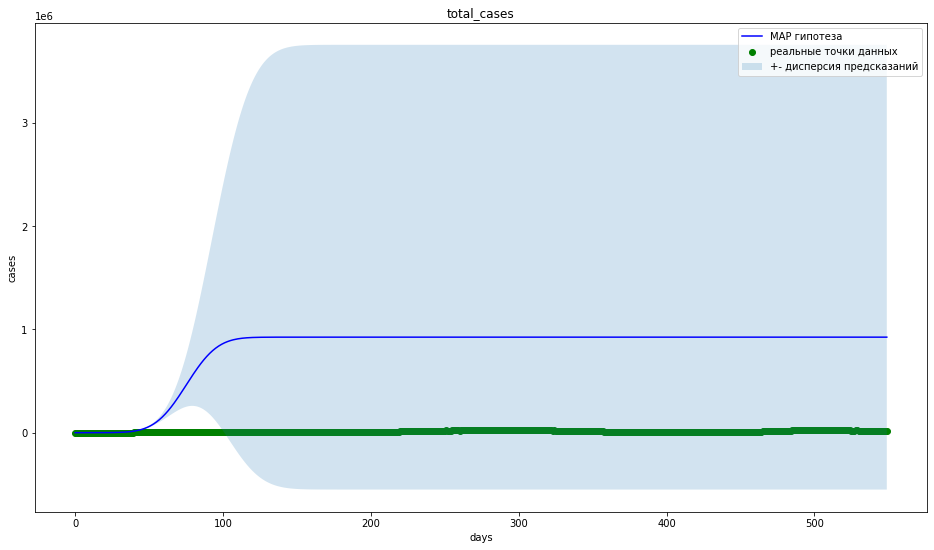

In [109]:

plot_predictions(days,
                 train_target[target].append(test_target[target]),
                 final_predict,
                 samples_total,
                 "total_cases",
                 "days",
                 "cases")

Далее можно сделать прогноз числа случаев коронавируса в пессимистичном сценарии (90-й процентиль в выборке числа случаев).

In [120]:
print("Общее количество заболевших короновируса в России (пессимистичный сценарий): " +
    str(sorted(final_predict)[:int(len(final_predict) * 0.9)][-1]))

Общее количество заболевших короновируса в России (пессимистичный сценарий): 924765.2258879169


В оптимистичном сценарии (10-й процентиль).

In [121]:
print("Общее количество заболевших короновируса в России (оптимистичный сценарий): " +
    str(sorted(final_predict)[:int(len(final_predict) * 0.1)][-1]))

Общее количество заболевших короновируса в России (оптимистичный сценарий): 93481.06695924631


В завершении хотелось бы сказать, что круто мы исследовали в пунке 2 экспоненту, ибо new_cases хуево оно предсказывается ей, а сумма бы еще хуже предсказывала total_cases (а мб и нет, хз, лучше бы чекнуть). Поэтому в первом пунку заебись предсказали total_cases как эксп, а во втором как сумму new_cases.